In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 13.7 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pickle

In [ ]:
def vec_check(vec,electron_num):
    """
    To check solution conserve the charge
    """
    for i,e in enumerate(vec):
        if np.abs(e) > 1e-8:
            e_occ=bin(i)[2:]
            lst=' '.join(e_occ).split(' ')
            cv=tuple(map(int, lst))
            e_num=sum(cv)
            if e_num!=electron_num:
                return False
    return True

def exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge):
    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.0001*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]

    print('The ground state energy with sz=0:',eng[0])
    E_collect=[eng[0]]

    elec_num=num_electrons

    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if  np.abs(Sz)<1e-5 and vec_check(vec[:,i],elec_num):
            print('The excited energy:',(eng[i]-0.0001*Sz).real, ' with Sz=', np.round(Sz.real,3))
            E_collect.append(eng[i])


    return E_collect

In [ ]:
r=1.0
a0=0.529177210903
L=r/a0
symbol=["H","H","H","H"]
geometry=np.array([0.0, 0.0, 0.0, L, 0.0, 0.0, 2*L, 0, 0, 3*L,0,0])#, 0, 0, 4*L, 0, 0, 5*L, 0, 0])

charge=0
#num_electrons=2
E_c,q=Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,basis="STO-3G",active_electrons=4)


In [ ]:
q

8

In [ ]:
r_lst=[0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4]
E_dict={}
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H","H","H","H"]
    geometry=np.array([0.0, 0.0, 0.0, L, 0.0, 0.0, 2*L, 0, 0, 3*L,0,0])

    charge=0
    num_electrons=4
    E_c=exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge)
    for i,e in enumerate(E_c):
        if i not in E_dict:
            E_dict[i]=[e]
        else:
            E_dict[i].append(e)

The ground state energy with sz=0: -2.1675605463844354
The excited energy: -1.807912190544876  with Sz= -0.0
The excited energy: -1.5145835733726418  with Sz= 0.0
The excited energy: -1.499120102282562  with Sz= 0.0
The excited energy: -1.4087404637822842  with Sz= 0.0
The excited energy: -1.085586970544463  with Sz= -0.0
The excited energy: -1.0627965252587999  with Sz= 0.0
The excited energy: -0.9104526642905713  with Sz= 0.0
The excited energy: -0.7793736739334944  with Sz= -0.0
The excited energy: -0.7555976474282615  with Sz= 0.0
The excited energy: -0.6714773911126263  with Sz= 0.0
The excited energy: -0.6080252657463797  with Sz= -0.0
The excited energy: -0.5256520892433928  with Sz= -0.0
The excited energy: -0.5110415214454779  with Sz= 0.0
The excited energy: -0.41860876084122917  with Sz= -0.0
The excited energy: -0.18356883748529831  with Sz= -0.0
The excited energy: -0.16021019549158547  with Sz= 0.0
The excited energy: -0.11036695742415949  with Sz= -0.0
The excited energy

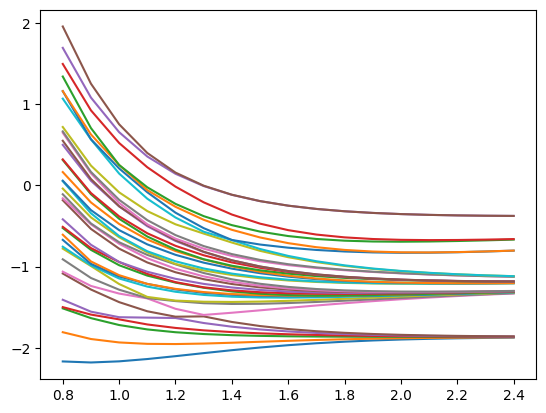

In [ ]:
for i in E_dict.keys():
    if len(r_lst)==len(E_dict[i]):
        plt.plot(r_lst,E_dict[i])


In [ ]:
def depth(qnode):
    def _fn(*args, **kwargs):
        qnode.construct(args, kwargs)
        return qnode.qtape.get_depth()
    return _fn

In [ ]:
def bit_to_vec(bitstring_dict,num_qubits):
    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [ ]:
class FS_VQD_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge) -> None:
        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)
        self.state_lst=[]
        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))
        H_matrix=qml.matrix(self.hamiltonian)
        H_sq=H_matrix.dot(H_matrix)
        self.H_sq_ob=qml.Hermitian(H_sq, wires=range(self.num_qubits))

        self.weight_dict={}
        self.th_state=0
        self.Eng_lst=[]

        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)
        self.cost_fid_fn = qml.QNode(self.circuit_fid, self.dev)
        self.cost_hsq_fn = qml.QNode(self.circuit_h_sq, self.dev)
        self.num_ly_lst=[]

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge):
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits):
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights):
        #qml.BasisState(state, wires=range(self.num_qubits))
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.hamiltonian)

    def circuit_h_sq(self,state,weights):
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.H_sq_ob)

    def circuit_sz(self,state,weights):
        #qml.BasisState(state, wires=range(self.num_qubits))
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.sz)

    def circuit_fid(self,state,params,weights,ind):
        #qml.BasisState(state, wires=range(num_qubits))
        qml.StatePrep(state, wires=range(self.num_qubits))
        Re_w=weights.copy()[::-1]
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(params[i+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(params[i+s_l+j*(d_l+s_l)], wires=self.doubles[i])

        Re_single=self.singles.copy()[::-1]
        Re_double=self.doubles.copy()[::-1]
        for j in range(self.num_ly_lst[ind]):
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(-Re_w[i+j*(d_l+s_l)], wires=Re_double[i])
            for i in range(len(self.singles)):
                qml.SingleExcitation(-Re_w[i+d_l+j*(d_l+s_l)], wires=Re_single[i])

        return qml.state() #qml.probs(wires=range(num_qubits))

    def cost_fn(self,params):
        cost=np.sqrt(self.cost_hsq_fn(self.stat,params)-2*self.om*self.cost_h_fn(self.stat,params)+self.om**2)
        for ind in range(self.th_state):
            coj_stat=np.conjugate(np.transpose(self.state_lst[ind]))
            final_stat=self.cost_fid_fn(self.stat,params,self.weight_dict[ind],ind)
            fid=np.abs(np.dot(coj_stat,final_stat))**2
            cost+=self.beta*fid#[stat_ind]
        return cost

    def fluctuation(self,stat,params):
        return self.cost_hsq_fn(stat,params)-self.cost_h_fn(stat,params)**2

    def run(self,om=0.0,beta=3.0,epochs=400,stepsize=0.5,num_layer=2,cov=1e-6,print_train=True):
        self.om=om
        if self.th_state==len(self.state_lst):
            print('Run of states')
            return None
        self.beta=beta
        self.stat=self.state_lst[self.th_state]
        self.num_layer=num_layer
        opt = qml.AdamOptimizer(stepsize=stepsize)
        self.weights =np.zeros(num_layer*len(self.singles+self.doubles), requires_grad=True)

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0

        cov=cov
        E_pev=0

        for _ in range(epochs):
            self.weights = opt.step(self.cost_fn, self.weights)
            iter.append(i)
            cost=self.cost_fn(self.weights)

            E0=self.cost_h_fn(self.stat,self.weights)

            cost_val.append(E0)

            i=i+1
            if print_train:
                print('iter:',i)
                print(' E0:',E0,' Sz:',self.Sz_fn(self.stat,self.weights))
                print(cost)
            if np.abs(E0-E_pev)<cov:
                break

            E_pev=E0
        self.fl=self.fluctuation(self.stat,self.weights)
        print('fluctuation:')
        print(self.fl)
        self.iter_lst=iter
        self.Eng_lst=E0
        self.weight_dict[self.th_state]=self.weights
        self.th_state+=1
        self.num_ly_lst.append(num_layer)
        return self.cost_h_fn(self.stat,self.weights)#, iter[-1]

## To Get excited states near $-1.0$ Ha

In [ ]:
r_lst1=[0.8,1.2,1.6,2.0,2.4]
E1_lst=[]
E2_lst=[]
E3_lst=[]

F1_lst=[]
F2_lst=[]
F3_lst=[]

iter1_lst=[]
iter2_lst=[]
iter3_lst=[]
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H","H","H","H"]
    geometry=np.array([0.0, 0.0, 0.0, L, 0.0, 0.0, 2*L, 0, 0, 3*L,0,0])

    charge=0
    num_electrons=4
    e_stat_1={'11011000': 1}
    e_stat_2={'01111000': 1}
    e_stat_3={'01111000': 1}
    stat_lst=[e_stat_1,e_stat_2,e_stat_3]
    FS_VQD=FS_VQD_ch(stat_lst,num_electrons,symbol,geometry,charge)
    E1=FS_VQD.run(om=-1.0,beta=5.0,epochs=400,stepsize=0.2,num_layer=5)
    F1=FS_VQD.fl
    iter_1=FS_VQD.iter_lst[-1]
    E2=FS_VQD.run(om=-1.0,beta=5.0,epochs=400,stepsize=0.2,num_layer=5)
    F2=FS_VQD.fl
    iter_2=FS_VQD.iter_lst[-1]
    E3=FS_VQD.run(om=-1.0,beta=5.0,epochs=400,stepsize=0.2,num_layer=5)
    F3=FS_VQD.fl
    iter_3=FS_VQD.iter_lst[-1]

    iter_lst=[iter_1,iter_2,iter_3]
    F_lst=[F1,F2,F3]
    E_lst=[E1,E2,E3]
    inds=np.argsort(E_lst)
    E1,E2,E3=np.array(E_lst)[inds]

    E1_lst.append(E1)
    E2_lst.append(E2)
    E3_lst.append(E3)

    F1,F2,F3=np.array(F_lst)[inds]

    F1_lst.append(F1)
    F2_lst.append(F2)
    F3_lst.append(F3)

    iter_1,iter_2,iter_3=np.array(iter_lst)[inds]

    iter1_lst.append(iter_1)
    iter2_lst.append(iter_2)
    iter3_lst.append(iter_3)

iter: 1
 E0: -0.21453075076038605  Sz: 0.0
1.3944357360754573
iter: 2
 E0: -0.3938048987384442  Sz: -1.3877787807814457e-17
0.9007645431933049
iter: 3
 E0: -0.5088573707828444  Sz: -4.163336342344337e-17
0.7829464934568545
iter: 4
 E0: -0.5395186003763804  Sz: 0.0
0.836591288520687
iter: 5
 E0: -0.6503138614506014  Sz: -2.7755575615628914e-17
0.7241663099493051
iter: 6
 E0: -0.8248378776064332  Sz: -2.7755575615628914e-17
0.48116889205035984
iter: 7
 E0: -0.9381741427280184  Sz: 0.0
0.4071456558974125
iter: 8
 E0: -0.9645770997589458  Sz: 5.551115123125783e-17
0.36806765760043986
iter: 9
 E0: -0.9486394371192711  Sz: 1.1102230246251565e-16
0.26851633880445736
iter: 10
 E0: -0.9140673566361717  Sz: -2.7755575615628914e-17
0.28829030454238774
iter: 11
 E0: -0.895806772314578  Sz: -2.7755575615628914e-17
0.30778362154700734
iter: 12
 E0: -0.8935835378998996  Sz: 0.0
0.27449506407189533
iter: 13
 E0: -0.9052462217345665  Sz: -2.7755575615628914e-17
0.25284531458988674
iter: 14
 E0: -0.9185

/usr/local/lib/python3.10/dist-packages/autograd/numpy/numpy_wrapper.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  return A.astype(dtype, order, casting, subok, copy)


Streaming output truncated to the last 5000 lines.
 E0: -0.9428891604908064  Sz: 2.7755575615628914e-17
0.06142100498307902
iter: 258
 E0: -0.9427016282449555  Sz: 0.0
0.06273765818652184
iter: 259
 E0: -0.942293484229975  Sz: 2.7755575615628914e-17
0.06635984726439874
iter: 260
 E0: -0.9420500068458751  Sz: 0.0
0.06922999470634647
iter: 261
 E0: -0.9423337742076107  Sz: -5.551115123125783e-17
0.06790602856151838
iter: 262
 E0: -0.9426861972625564  Sz: 2.7755575615628914e-17
0.06333085947292098
iter: 263
 E0: -0.9430904381797308  Sz: 2.7755575615628914e-17
0.060780260858929035
iter: 264
 E0: -0.9430603578267927  Sz: 0.0
0.06093638712552663
iter: 265
 E0: -0.9430338441316679  Sz: -5.551115123125783e-17
0.06332679149284252
iter: 266
 E0: -0.9428362156378534  Sz: 2.7755575615628914e-17
0.06573038088347227
iter: 267
 E0: -0.9429081829680726  Sz: 2.7755575615628914e-17
0.06456286538960546
iter: 268
 E0: -0.9430244234984348  Sz: 0.0
0.06238970994148468
iter: 269
 E0: -0.9431115562413519  Sz:

In [ ]:
r_lst1=[0.8,1.2,1.6,2.0,2.4]

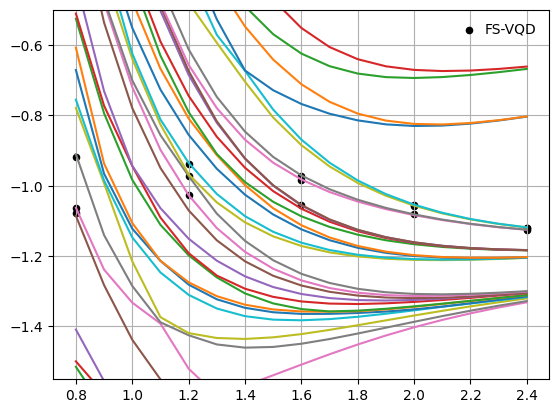

In [ ]:
for i in E_dict.keys():
    if len(r_lst)==len(E_dict[i]) :
        plt.plot(r_lst,E_dict[i])

plt.scatter(r_lst1,E1_lst,s=20,c='k',label='FS-VQD')
plt.scatter(r_lst1,E2_lst,s=20,c='k')
plt.scatter(r_lst1,E3_lst,s=20,c='k')

plt.legend(frameon=False,labelspacing = 0.09,handlelength=0.7)
plt.ylim(-1.55,-0.5)
#plt.legend()
plt.grid()

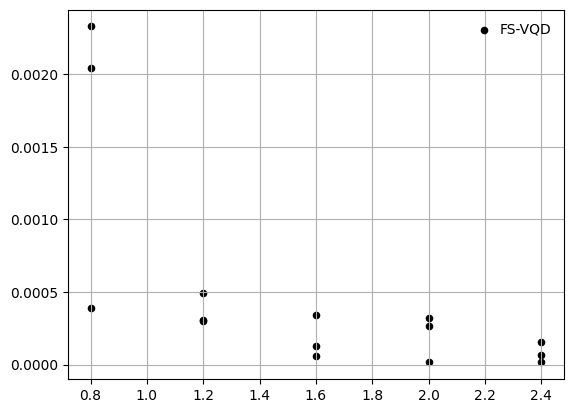

In [ ]:
plt.scatter(r_lst,F1_lst,s=20,c='k',label='FS-VQD')
plt.scatter(r_lst,F2_lst,s=20,c='k')
plt.scatter(r_lst,F3_lst,s=20,c='k')

plt.legend(frameon=False,labelspacing = 0.09,handlelength=0.7)
#plt.legend()
plt.grid()

In [ ]:
with open('H4_E.pickle', 'wb') as handle:
    pickle.dump(E_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('FS_VQD_0.npy', 'wb') as f:
    np.save(f, np.array(E1_lst))

with open('FS_VQD_1.npy', 'wb') as f:
    np.save(f, np.array(E2_lst))

with open('FS_VQD_2.npy', 'wb') as f:
    np.save(f, np.array(E3_lst))

In [ ]:
with open('FS_VQD_F0.npy', 'wb') as f:
    np.save(f, np.array(F1_lst))

with open('FS_VQD_F1.npy', 'wb') as f:
    np.save(f, np.array(F2_lst))

with open('FS_VQD_F2.npy', 'wb') as f:
    np.save(f, np.array(F3_lst))